In [39]:
# following https://stackoverflow.com/questions/45492703/google-drive-api-oauth-and-service-account

In [5]:
#  ! pip install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib google-cloud-translate

In [6]:
# ! pip install transformers==3.1
# ! pip3 install --upgrade tensorflow-gpu

In [2]:
from google.cloud import translate

import json
from tqdm.auto import tqdm

from transformers import pipeline
import time
import re
from nltk.tokenize import sent_tokenize
import pandas as pd
import numpy as np

In [3]:
tqdm.pandas()

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [4]:
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'data/service.json'

In [5]:
from google.oauth2 import service_account
from googleapiclient.discovery import build

SCOPES = ['https://www.googleapis.com/auth/documents.readonly']
SCOPES += ['https://www.googleapis.com/auth/drive.metadata.readonly']
SERVICE_ACCOUNT_FILE = 'data/service.json'

creds = service_account.Credentials.from_service_account_file(
        SERVICE_ACCOUNT_FILE, scopes=SCOPES)

In [6]:
def get_doc_content(doc_id):
    service = build('docs', 'v1', credentials=creds)

    # Retrieve the documents contents from the Docs service.
    document = service.documents().get(documentId=doc_id).execute()

    paragraphs = [paragraph['paragraph'] for paragraph in document['body']['content'] if 'paragraph' in paragraph]
    elements = [element['textRun']['content'] for p in paragraphs for element in p['elements'] if 'textRun' in element]
    
    return ''.join(elements)



In [7]:
# get file
# get date per file
# translate file
# get file sentiment

In [8]:
def translate_text(text="Hello, world!", project_id="swift-clarity-183805"):

    client = translate.TranslationServiceClient()
    location = "global"
    parent = f"projects/{project_id}/locations/{location}"
    
    response = client.translate_text(
        request={
            "parent": parent,
            "contents": [text],
            "mime_type": "text/plain",
            "source_language_code": "he",
            "target_language_code": "en-US",
        }
    )

    for translation in response.translations:
        yield("Translated text: {}".format(translation.translated_text))



In [9]:
def split_to_sentences(data):
    if type(data)==str:
        data = [data]
    sentences = [s for d in data for s in d.split('\n')]
    sentences = [s.strip() for s in sentences]
    sentences = [re.sub('&#39;', '\'', s) for s in sentences]
    sentences = [re.sub('…', '...', s) for s in sentences]
    sentences = [s for line in sentences for s in sent_tokenize(line) if s]
    new_sentences = []
    for s in sentences:
        if len(s)>=512:
            new_sentences += s.split(',')
        else:
            new_sentences.append(s)
    return new_sentences

In [22]:
service = build('drive', 'v3', credentials=creds)
file_list = service.files().list(pageSize=1000).execute()
files = file_list['files']
for f in tqdm(files):
    f.update(service.files().get(fileId=f['id'], fields="createdTime").execute())
files_df = pd.DataFrame(files)
files_df.to_csv('data/thoughts/files_metadata.csv')

In [30]:
files_df = pd.read_csv('data/thoughts/files_metadata.csv', index_col=0)

In [36]:
for file in tqdm(files):
    try:
        if file['mimeType']!='application/vnd.google-apps.document':
            continue
        if os.path.exists(f"data/thoughts/ids/{file['id']}.txt"):
            continue
        content = get_doc_content(file['id'])
        translation = translate_text(content)
        with open(f'data/thoughts/ids/{file["id"]}.txt', 'w') as f:
            f.write('\n'.join(translation))
    except KeyError:
        print(file)

In [10]:
sentiment_pipeline = pipeline("sentiment-analysis")

All model checkpoint weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [11]:
def get_sentiment(data):
    data = split_to_sentences(data)
    sentiments = sentiment_pipeline(data)
    score = sum(s['score'] if s['label']=='POSITIVE' else -s['score'] for s in sentiments)/len(sentiments)
    return score

In [63]:
# ! mkdir data/thoughts/ids

In [11]:
# pd.DataFrame([[None,None]], columns=['id','score']).to_csv('data/thoughts/id_sentiment.csv')

In [31]:
sentiment_df = pd.read_csv('data/thoughts/id_sentiment.csv', index_col=0)

In [14]:
dirname = 'data/thoughts/ids'

In [23]:
d = {}
done = set(sentiment_df['id'])
# done = {}
for fname in tqdm(os.listdir(dirname)):
    if not fname.endswith('.txt'):
        continue
    id = re.sub('.txt', '', fname)
    print(id)
    if id in done:
        continue
    with open(os.path.join(dirname,fname)) as f:
        data = f.read()
    score = get_sentiment(data[:512]) #TODO: maybe batch
    df = pd.DataFrame([[id,score]], columns=['id','score'])
    sentiment_df = pd.concat([sentiment_df,df])
    sentiment_df.to_csv('data/thoughts/id_sentiment.csv')    

In [15]:
with open(os.path.join(dirname,fname)) as f:
    data = f.read()



In [17]:
len(split_to_sentences(data))

825

In [34]:
files_df = files_df.merge(sentiment_df, on='id')

In [53]:
files_df = files_df[~files_df.index.duplicated(keep='first')]

In [56]:
files_df_bfill = files_df.resample('D').bfill()

In [110]:
files_df_bfill['MA'] = files_df_bfill['score'].rolling(window=30).mean()

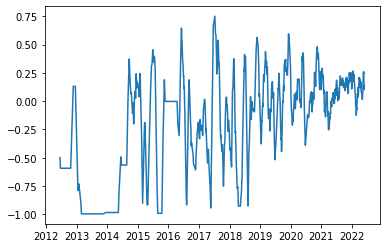

In [111]:
plt.plot(files_df_bfill.index.to_pydatetime(), files_df_bfill['MA'])